# 0.0 Imports


In [1]:
import pandas as pd
import seaborn as sns

from utils.data_engineer import split_temporal_data
from utils.metrics import ml_error, get_model_performance, models_cross_validation

import xgboost as xgb
from catboost              import CatBoostRegressor
from sklearn.ensemble      import RandomForestRegressor
from sklearn.neighbors     import KNeighborsRegressor
from sklearn.linear_model  import LinearRegression,Lasso



## 0.1 loading data

In [2]:
df_raw = pd.read_csv(r"C:\Users\alexandre.fonseca\Documents\repos\tcc\data\FPM-por-Municipio.csv", sep=';',encoding="latin1")


## 0.2 Helper Functions

# 1.0 Data Description

In [3]:
df1 = df_raw.copy()

## 1.1 rename columns

In [4]:
df1.columns  = ['codigo', 'municipio', 'uf', 'municipio_uf', 'mes', '1996', '1997',
       '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006',
       '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
       '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024',
       '2025']

## 1.2 Data Dimensions

In [5]:
print(" Number of rows {}".format( df1.shape[0] ) )
print(" Number of cols {}".format( df1.shape[1] ) )

 Number of rows 66848
 Number of cols 35


## 1.3 Data Types

In [6]:
df1.dtypes


codigo          float64
municipio        object
uf               object
municipio_uf     object
mes             float64
1996             object
1997             object
1998             object
1999             object
2000             object
2001             object
2002             object
2003             object
2004             object
2005             object
2006             object
2007             object
2008             object
2009             object
2010             object
2011             object
2012             object
2013             object
2014             object
2015             object
2016             object
2017             object
2018             object
2019             object
2020             object
2021             object
2022             object
2023             object
2024             object
2025             object
dtype: object

## 1.4 Check NA

In [7]:
df1.isna().sum()


codigo          8
municipio       8
uf              8
municipio_uf    8
mes             8
1996            8
1997            8
1998            8
1999            8
2000            8
2001            8
2002            8
2003            8
2004            8
2005            8
2006            8
2007            8
2008            8
2009            8
2010            8
2011            8
2012            8
2013            8
2014            8
2015            8
2016            8
2017            8
2018            8
2019            8
2020            8
2021            8
2022            8
2023            8
2024            8
2025            8
dtype: int64

# 2.0 Data Engineering

In [8]:
df2 = df1.copy()


## 2.1 Data filtering

In [9]:
CODIGO_CATALAO = 9301

df2 = df2[df2['codigo'] == CODIGO_CATALAO]


## 2.2 remove cols

In [10]:
cols_to_remove = ['municipio', 'municipio_uf','uf']
df2 = df2.drop(cols_to_remove, axis=1)

## 2.3 Data engineering

In [11]:
## 2.4 Melt dos dados
# Criando lista de colunas de anos
anos = [str(ano) for ano in range(1996, 2026)]

# Fazendo o melt dos dados
df2 = pd.melt(df2, 
              id_vars=['codigo', 'mes'],
              value_vars=anos,
              var_name='ano',
              value_name='valor')

# Convertendo o ano para inteiro
df2['ano'] = df2['ano'].astype(int)

In [12]:
df2 = df2[df2['valor'] != ' -   ']

In [13]:
# Convertendo o valor para float (removendo pontos e vírgulas)
df2['valor'] = df2['valor'].str.replace('.', '').str.replace(',', '.').astype(float)

In [14]:
df2["mes"] = df2["mes"].astype(int)

In [15]:
df2['data'] = df2['ano'].astype(str) + '-' + df2['mes'].astype(str)
df2['data'] = pd.to_datetime(df2['data'])
df2.head()

,codigo,mes,ano,valor,data
0,9301.0,1,1996,260380.68,1996-01-01
1,9301.0,2,1996,264623.42,1996-02-01
2,9301.0,3,1996,229935.32,1996-03-01
3,9301.0,4,1996,405094.47,1996-04-01
4,9301.0,5,1996,260597.71,1996-05-01


In [16]:
# Ordenando os dados
df2 = df2.sort_values(['ano', 'mes'])

# 3.0 Exploratory Data Analysis


In [17]:
df3 = df2.copy()


##  3.1 Univariate Analysis

### 3.1.1 Response Variable

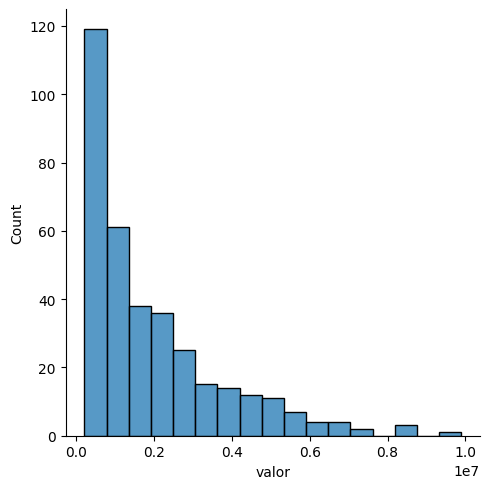

In [18]:
sns.displot(df3["valor"])

Observações: 
- Distribuição de cauda longa para a variável que queremos prever

<Axes: xlabel='data', ylabel='valor'>

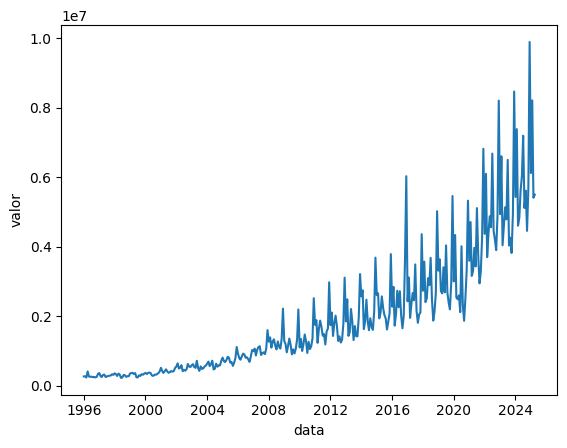

In [19]:
sns.lineplot(x="data", y="valor", data=df3)

# 4.0 Data Preparation

In [20]:
df4 = df3.copy()

# 5.0 Feature Selection

In [21]:
df5 = df4.copy()

##  5.1 Split training and test

In [22]:
X_train, X_test, y_train, y_test = split_temporal_data(df5)

# Para o cross validation, vamos usar X_train que ainda tem a coluna 'data' e a coluna 'valor'
X_train_cv = pd.concat([X_train, y_train], axis=1)
print("Dados de treino com range de data: ", X_train["data"].min(), "a", X_train["data"].max())

print("Dados de teste com range de data: ", X_test["data"].min(), "a", X_test["data"].max())



Dados de treino com range de data:  1996-01-01 00:00:00 a 2019-05-01 00:00:00
Dados de teste com range de data:  2019-06-01 00:00:00 a 2025-04-01 00:00:00


# 6.0 Machine Learning

## 6.1 Base Line - Average Model

In [23]:
# Para o baseline, vamos usar X_test que ainda tem a coluna 'data'
aux1 = X_test.copy()
aux1["valor"] = y_test.copy()

In [24]:
aux2 = aux1[['ano','valor']].groupby('ano').mean().reset_index().rename(columns={'valor':'predictions'})

In [25]:
aux1 = pd.merge(aux1,aux2 ,on='ano', how='left')

In [26]:
yhat_baseline = aux1['predictions']

In [27]:
baseline_result = ml_error("Baseline - Average Model", y_test.to_numpy(),yhat_baseline.to_numpy())

In [28]:
baseline_result

,Model Name,MAE,MAPE,RMSE,MPE
0,Baseline - Average Model,932688.16,0.21,1206097.24,-0.06


## 6.2 Machine Learning models

In [29]:
# Removendo a coluna 'data' que não deve ser usada como feature
# (ela é datetime e causava o erro de DTypePromotionError)
X_train_clean = X_train.drop(['data'], axis=1)
X_test_clean = X_test.drop(['data'], axis=1)

#define models
lr  = LinearRegression( )
lrr = Lasso( alpha=0.01 )
rf  = RandomForestRegressor( n_estimators = 20, n_jobs=-1, random_state = 42) 
knr = KNeighborsRegressor( n_neighbors = 2)
cat = CatBoostRegressor(verbose=False)
xgb = xgb.XGBRFRegressor()


models= [lr , lrr, rf ,  knr,  cat, xgb]
#prediction
df_performance , yhat = get_model_performance(models, X_train_clean, y_train, X_test_clean, y_test )
df_performance = pd.concat([df_performance ,  baseline_result ]).reset_index().drop( 'index', axis=1)

Training LinearRegression ...
Training Lasso ...
Training RandomForestRegressor ...
Training KNeighborsRegressor ...
Training CatBoostRegressor ...
Training XGBRFRegressor ...


In [30]:
df_performance.style.highlight_min(color='darkblue')

,Model Name,MAE,MAPE,RMSE,MPE
0,LinearRegression,1644188.780000,0.310000,2130383.870000,0.250000
1,Lasso,1644188.780000,0.310000,2130383.870000,0.250000
2,RandomForestRegressor,1608781.940000,0.310000,1978457.240000,0.260000
3,KNeighborsRegressor,1812725.840000,0.350000,2226456.450000,0.300000
4,CatBoostRegressor,1616129.120000,0.310000,1989932.760000,0.270000
5,XGBRFRegressor,1738858.200000,0.330000,2137284.210000,0.300000
6,Baseline - Average Model,932688.160000,0.210000,1206097.240000,-0.060000


## 6.3 Cross Validation

In [31]:
df_cross = models_cross_validation(models, X_train_cv)

Training... LinearRegression...
Iteration 5 - Validating from 2016-11-01 to 2017-05-01
Iteration 4 - Validating from 2017-05-01 to 2017-11-01
Iteration 3 - Validating from 2017-11-01 to 2018-05-01
Iteration 2 - Validating from 2018-05-01 to 2018-11-01
Iteration 1 - Validating from 2018-11-01 to 2019-05-01
Training... Lasso...
Iteration 5 - Validating from 2016-11-01 to 2017-05-01
Iteration 4 - Validating from 2017-05-01 to 2017-11-01
Iteration 3 - Validating from 2017-11-01 to 2018-05-01
Iteration 2 - Validating from 2018-05-01 to 2018-11-01
Iteration 1 - Validating from 2018-11-01 to 2019-05-01
Training... RandomForestRegressor...
Iteration 5 - Validating from 2016-11-01 to 2017-05-01
Iteration 4 - Validating from 2017-05-01 to 2017-11-01
Iteration 3 - Validating from 2017-11-01 to 2018-05-01
Iteration 2 - Validating from 2018-05-01 to 2018-11-01
Iteration 1 - Validating from 2018-11-01 to 2019-05-01
Training... KNeighborsRegressor...
Iteration 5 - Validating from 2016-11-01 to 2017-0

In [32]:
df_cross

,Model Name,MAE,MAPE,RMSE,MPE
0,LinearRegression KFold: 5,1030468.96,0.25,1598395.52,0.21
1,LinearRegression KFold: 4,441211.66,0.18,539414.02,-0.04
2,LinearRegression KFold: 3,640822.84,0.18,897481.75,0.14
3,LinearRegression KFold: 2,487032.95,0.18,598871.72,0.01
4,LinearRegression KFold: 1,740935.4,0.19,1070005.21,0.19
5,LinearRegression - Cross-Validation,668094.36 +/- 210534.51,0.2 +/- 0.03,940833.64 +/- 381844.99,0.1 +/- 0.1
6,Lasso KFold: 5,1030468.96,0.25,1598395.53,0.21
7,Lasso KFold: 4,441211.66,0.18,539414.02,-0.04
8,Lasso KFold: 3,640822.84,0.18,897481.75,0.14
9,Lasso KFold: 2,487032.95,0.18,598871.72,0.01
